### Import libraries

In [1]:
%matplotlib inline

import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.json import json_normalize

import matplotlib
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *

import time

from datetime import datetime
from dateutil import tz

from lxml import objectify

from bibliopixel import *
from bibliopixel.drivers.LPD8806 import *
from bibliopixel import LEDStrip
import bibliopixel.colors as colors

### Setting paths for different data files

In [2]:
path = ((141501550,'Dunne_1Sep2015_14Feb2016_meter141501550.xml'), 
        (141654340,'Dunne_1Sep2015_14Feb2016_meter141654340.xml'), 
        (141654341,'Dunne_1Sep2015_14Feb2016_meter141654341.xml'),
        (145019813,'Dunne_1Sep2015_14Feb2016_meter145019813.xml'),
        (23007980,'Dunne_1Sep2015_14Feb2016_meter230079804.xml'),
        (230083235,'Dunne_1Sep2015_14Feb2016_meter230083235.xml')
       )


In [3]:
tz_offset = -21600 + 3600 #Central DST
def xml_df(path, meterID):
    
    xml = objectify.parse(open(path))
    root = xml.getroot()
    obj_top = root.getchildren()[6].getchildren()[4].getchildren()
    length = len(obj_top)
    
    df = pd.DataFrame(columns=('duration', 'time_stamp', 'value', 'meter ID')) 
    
    for i in range(length): #takes a while to run 
        length2 = len(obj_top[i].getchildren())
        for j in range(1, length2): # element 0 is info. 
        
            obj = obj_top[i].getchildren()[j].getchildren()
            row = dict(zip(['duration', 'time_stamp', 'value', 'meter ID'], 
                           [int(obj[0].getchildren()[0]), int(obj[0].getchildren()[1])+tz_offset, float(obj[1]), meterID]))
            row_s = pd.Series(row)
            row_s.name = (i*length2) + (j-1)
            df = df.append(row_s)
            
    df['time_stamp']=pd.to_datetime(df['time_stamp'],unit='s')
    df['value']=df.value/1000
    
    return df



In [10]:
def gbplot(df,clr,meterID):
    ax=df.plot(x='time_stamp', y='value',title="Dunne-meter"+str(meterID),marker='.',color=clr)
    plt.gcf().autofmt_xdate()
    
    ax.set_xlabel("Date")
    ax.set_ylabel("kWh")
    
    #scatter(df1['datetime'],df1['value'])
    #ax.set_xlim(['2015-01-01 00:00:00','2016-03-07 00:00:00']) #FULL RANGE
    #ax.set_xlim(['2014-01-01 00:00:00','2014-12-31 00:00:00']) #Look at 2014
    #ax.set_xlim(['2015-09-01 00:00:00','2015-09-30 00:00:00']) #Look at September 2014
    #ax.set_xlim(['2015-09-07 00:00:00','2015-09-14 00:00:00']) #Look at One week in September 2014
    #ax.set_xlim(['2015-09-09 00:00:00','2015-09-10 00:00:00']) #Look at Weekday in September 2014
    return

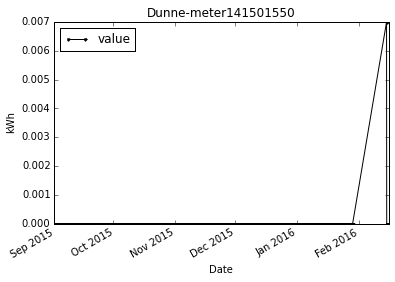

In [11]:
## Meter 1
meterID = path[0][0]
current_path = path[0][1]
df_1 = xml_df(current_path, meterID)

gbplot(df_1,'black',meterID)


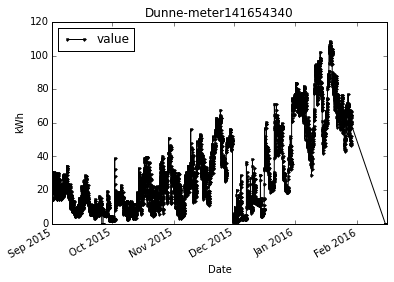

In [12]:
## Meter 2
meterID = path[1][0]
current_path = path[1][1]
df_2 = xml_df(current_path, meterID)

gbplot(df_2,'black',meterID)


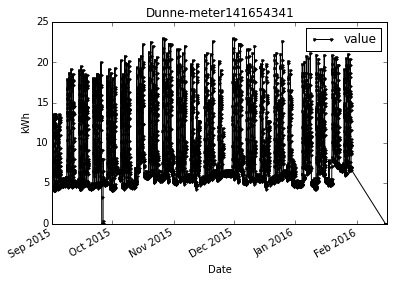

In [13]:
## Meter 3
meterID = path[2][0]
current_path = path[2][1]
df_3 = xml_df(current_path, meterID)

gbplot(df_3,'black',meterID)


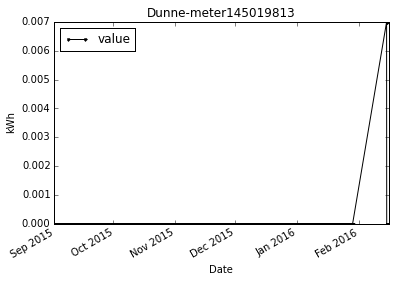

In [14]:
## Meter 4
meterID = path[3][0]
current_path = path[3][1]
df_4 = xml_df(current_path, meterID)

gbplot(df_4,'black',meterID)

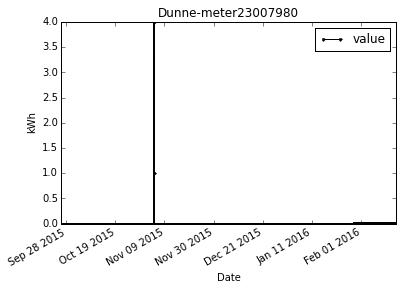

In [15]:
## Meter 5
meterID = path[4][0]
current_path = path[4][1]
df_5 = xml_df(current_path, meterID)

gbplot(df_5,'black',meterID)

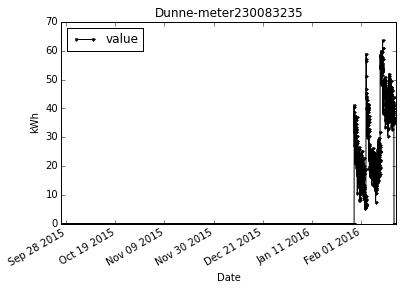

In [16]:
## Meter 6
meterID = path[5][0]
current_path = path[5][1]
df_6 = xml_df(current_path, meterID)

gbplot(df_6,'black',meterID)

(0, 50)

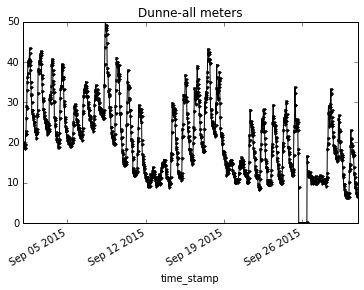

In [30]:
df_total = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])
df_total
df_group = df_total.groupby('time_stamp')
df_new = df_group['value'].sum()

ax = df_new.plot(title="Dunne-all meters",marker='.',color='black')

#ax.set_xlim(['2015-09-09 00:00:00','2015-09-10 00:00:00'])  ## For 1 day value
ax.set_xlim(['2015-09-01 00:00:00','2015-10-01 00:00:00']) ## For September alone
ax.set_ylim([0,50])

### Generating color scale

In [41]:
red = 0
green = 255
stepSize = 50
color_gn_rd = []
color_gn_rd.append((red, green, 0)) ## the lights are GRB format

In [43]:
while(red < 255): ## start with green and increase red
    red += stepSize;
    if(red > 245):
        red = 255; 
    color_gn_rd.append((red, green, 0))

while(green > 0): ## start with red + green and decrease green
    green -= stepSize;
    if(green < 6):
        green = 0; 
    color_gn_rd.append((red, green, 0)); 
    
total_colors = len(color_gn_rd)
total_colors

11

### Setting up LEDs

In [39]:
LedsPerSide = 10
numLeds= LedsPerSide*4*2 ##x/side * 4 sides * 2 levels
driver=DriverLPD8806(numLeds, ChannelOrder.BRG)
led=LEDStrip(driver)

ERROR - spi_driver_base - Unable to import spidev. Please install. pip install spidev
ERROR:BiblioPixel:Unable to import spidev. Please install. pip install spidev


ImportError: Unable to import spidev. Please install. pip install spidev

### Defining Flashing modes

In [62]:
def led_set(start_position, numLEDs, color): ## Fills the colors
    led.fill(color, start=start_position,end=start_position+numLEDs)
    led.update()
    #print color
    return

def pulse(start_position, numLEDs, color):
    ## Step-up intensity by 10% increments, then step down by the same every 0.1 seconds. total time = 4 sec
    
    intensity = np.arange(0,1.1,0.1) 

    for i in intensity:
        color_new = (int(color[0]*i),int(color[1]*i),int(color[2]*i)) 
        # There is probably a more elegant way to do this.. 
        led.fill(color_new, start=start_position,end=start_position+numLEDs)
        led.update()
        time.sleep(0.2)

    for i in reversed(intensity):
        color_new = (color[0]*i,color[1]*i,color[3]*i) 
        led.fill(color_new, start=start_position,end=start_position+numLEDs)
        led.update()
        time.sleep(0.2)        

In [70]:
print ('Starting Display')
print ('Press \'control + c\' to stop' )


Starting Display
Press 'control + c' to stop


### Calculate Average Data

In [61]:
#Averaged by Month

df_total['Month'] = pd.DatetimeIndex(df_total['time_stamp']).month
df_Monthlygroup = df_total.groupby('Month')
df_MonthlyAverage = df_Monthlygroup['value'].mean()

#Averaged by Day

df_total['Date'] = pd.DatetimeIndex(df_total['time_stamp']).date
df_Dailygroup = df_total.groupby('Date')
df_DailyAverage = df_Dailygroup['value'].mean()
df_RollingMean = pd.rolling_mean(df_DailyAverage, 30)


3.6225833333333326

### Displaying Daily Values

In [54]:
min_value = df_DailyAverage.min()
max_value = df_DailyAverage.max()
ScalingSteps = (max_value - min_value)/(total_colors - 1)
ScalingSteps


2.4753895833333335

In [55]:
for item in df_DailyAverage.iteritems():
    print 'Date: ', item[0]
    print 'Average use: ', item [1]
    color_index = int(item[1]/ScalingSteps)
    
    # print color_index
    color = color_gn_rd[color_index]
    led_set(0, 80, color)

Date:  2015-09-01
Average use:  7.35225
2
(100, 255, 0)
Date:  2015-09-02
Average use:  7.73325
3
(150, 255, 0)
Date:  2015-09-03
Average use:  7.16625
2
(100, 255, 0)
Date:  2015-09-04
Average use:  6.774
2
(100, 255, 0)
Date:  2015-09-05
Average use:  5.792625
2
(100, 255, 0)
Date:  2015-09-06
Average use:  6.916125
2
(100, 255, 0)
Date:  2015-09-07
Average use:  7.066875
2
(100, 255, 0)
Date:  2015-09-08
Average use:  8.298375
3
(150, 255, 0)
Date:  2015-09-09
Average use:  6.84675
2
(100, 255, 0)
Date:  2015-09-10
Average use:  5.422125
2
(100, 255, 0)
Date:  2015-09-11
Average use:  4.605
1
(50, 255, 0)
Date:  2015-09-12
Average use:  2.773125
1
(50, 255, 0)
Date:  2015-09-13
Average use:  3.153
1
(50, 255, 0)
Date:  2015-09-14
Average use:  4.588875
1
(50, 255, 0)
Date:  2015-09-15
Average use:  5.67225
2
(100, 255, 0)
Date:  2015-09-16
Average use:  6.43125
2
(100, 255, 0)
Date:  2015-09-17
Average use:  7.36725
2
(100, 255, 0)
Date:  2015-09-18
Average use:  6.587625
2
(100, 25

### Displaying Daily Values on Bottom with last 30 days average on Top

In [ ]:
min_value = df_DailyAverage.min()
max_value = df_DailyAverage.max()
ScalingSteps = (max_value - min_value)/(total_colors - 1)
ScalingSteps

In [64]:
count = 0
for item in df_DailyAverage.iteritems():
    print 'Date: ', item[0]
    print 'Average use: ', item [1]
    color_index = int(item[1]/ScalingSteps)
    
    # print color_index
    color = color_gn_rd[color_index]
    led_set(0, 40, color)
    
    print 'Last 30 days average: ', df_RollingMean[count]
    try:
        color_index = int(df_RollingMean[count]/ScalingSteps)
        color = color_gn_rd[color_index]
        led_set(40, 80, color)

    except:
        color = (0,0,0)
        led_set(40, 80, color)
    
    count = count + 1
        
    

Date:  2015-09-01
Average use:  7.35225
(100, 255, 0)
Last 30 days average:  nan
(0, 0, 0)
Date:  2015-09-02
Average use:  7.73325
(150, 255, 0)
Last 30 days average:  nan
(0, 0, 0)
Date:  2015-09-03
Average use:  7.16625
(100, 255, 0)
Last 30 days average:  nan
(0, 0, 0)
Date:  2015-09-04
Average use:  6.774
(100, 255, 0)
Last 30 days average:  nan
(0, 0, 0)
Date:  2015-09-05
Average use:  5.792625
(100, 255, 0)
Last 30 days average:  nan
(0, 0, 0)
Date:  2015-09-06
Average use:  6.916125
(100, 255, 0)
Last 30 days average:  nan
(0, 0, 0)
Date:  2015-09-07
Average use:  7.066875
(100, 255, 0)
Last 30 days average:  nan
(0, 0, 0)
Date:  2015-09-08
Average use:  8.298375
(150, 255, 0)
Last 30 days average:  nan
(0, 0, 0)
Date:  2015-09-09
Average use:  6.84675
(100, 255, 0)
Last 30 days average:  nan
(0, 0, 0)
Date:  2015-09-10
Average use:  5.422125
(100, 255, 0)
Last 30 days average:  nan
(0, 0, 0)
Date:  2015-09-11
Average use:  4.605
(50, 255, 0)
Last 30 days average:  nan
(0, 0, 0)